## Project

### Imports

In [ ]:
import torch
from torch import nn, Tensor
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import MNIST
from torch.optim import Adam
from tqdm.notebook import tqdm
from sklearn.cluster import MiniBatchKMeans
from torchvision import transforms
import matplotlib.pyplot as plt
from torchvision.transforms import Resize,Compose,ToTensor,Normalize
from PIL import Image
import numpy as np
import random

### Data Modules

### Modules

In [ ]:
class CustomMNISTDataset(MNIST):
    def __init__(self, *arg, **kw):       
        super(CustomMNISTDataset, self).__init__(*arg, **kw)
        self.transform =Resize((16,16))
        self.seq_len = 256
        
    def __getitem__(self, index: int):
        """
        returns flattened images and position encodings
        """
        img, target = self.data[index], int(self.targets[index]) 
        img = Image.fromarray(img.numpy(), mode='L')
        img = self.transform(img)
        img  = torch.from_numpy(np.array(img))
        return img.type(torch.long).view(256,), target

        

In [ ]:
train_ds = CustomMNISTDataset(root="./", download=True)
train_dl = DataLoader(train_ds, batch_size=256)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./CustomMNISTDataset/raw/train-images-idx3-ubyte.gz to ./CustomMNISTDataset/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./CustomMNISTDataset/raw/train-labels-idx1-ubyte.gz to ./CustomMNISTDataset/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./CustomMNISTDataset/raw/t10k-images-idx3-ubyte.gz to ./CustomMNISTDataset/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./CustomMNISTDataset/raw/t10k-labels-idx1-ubyte.gz to ./CustomMNISTDataset/raw



3

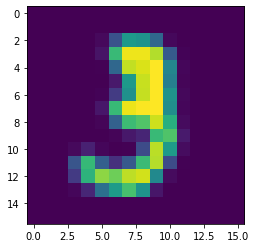

In [ ]:
plt.imshow(train_ds[10][0].reshape(-1,16))
train_ds[10][1]

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, dim_model: int, n_heads:int):
        
        super(MultiHeadAttention, self).__init__()
        
        assert dim_model%n_heads == 0
        
        self.dim_model = dim_model
        self.n_heads = n_heads
        self.head_dim = dim_model//n_heads
        
        self.query_layer = nn.Linear(dim_model, dim_model)
        self.key_layer = nn.Linear(dim_model, dim_model)
        self.value_layer = nn.Linear(dim_model, dim_model)
        
        self.final_layer = nn.Linear(dim_model, dim_model)

    def forward(self, query: Tensor, key: Tensor, value: Tensor, to_mask:bool) -> Tensor:
        batch_size = query.shape[0]
        
        query = self.query_layer(query)
        key = self.key_layer(key)
        value = self.value_layer(value)
        
        query = self.split_heads(query, batch_size=batch_size)
        key = self.split_heads(key, batch_size=batch_size)
        value = self.split_heads(value, batch_size=batch_size)
        output = self.scaled_dot_product(query, key, value, to_mask)

        # concat the heads back together
        output = output.view(batch_size, -1, self.dim_model)
        return self.final_layer(output)
        
    def scaled_dot_product(self, query: Tensor, key: Tensor, value: Tensor, to_mask:bool)-> Tensor:
        mask = self.create_mask(query, key, to_mask)
        coefficients = torch.matmul(query, key.transpose(-1, -2))
        scale = query.size(-1) ** 0.5
        scaled_coefficients = coefficients / scale
        masked_coeff = scaled_coefficients+(mask*(-1e11))
        #scaled_coefficients = F.softmax(masked_coeff, dim=-1)
        return torch.matmul(scaled_coefficients, value)
    def create_mask(self, query, key, to_mask):
        shp1, shp2 = query.shape[-2], key.shape[-2]
        mask = torch.ones(shp1, shp2, device=query.device)
        if to_mask:
            mask = torch.triu(mask, diagonal=1)
        else:
            mask = mask*0
        return mask
    
    def split_heads(self, x: Tensor, batch_size: int) -> Tensor:
        # (batch_size, seq_len, dim_model) => (batch_size, n_heads, seq_len, head_dim)
        
        # split dim_model dimension into n_heads*head_dim 
        # i.e (batch_size, seq_len, dim_model) => batch_size, seq_len, n_heads, head_dim)
        x = x.view(batch_size, -1, self.n_heads, self.head_dim)
        
        # batch_size, seq_len, n_heads, head_dim) => batch_size, n_heads, seq_len, head_dim)
        x = torch.permute(x, (0, 2, 1, 3))
        
        return x

In [ ]:
## test
mha = MultiHeadAttention(dim_model=64, n_heads=16)
q = v = k = torch.randn(24, 30, 64)
to_mask=True
print(mha(q, k, v, to_mask).shape)

torch.Size([24, 30, 64])


In [ ]:
## can be replaced with a sequential block as well.. but let's keep structure similar
class FeedForwardBlock(nn.Module):
    def __init__(self, dim_model:int,  dim_ff: int):
        super(FeedForwardBlock, self).__init__()
        
        self.dense1 = nn.Linear(dim_model, dim_ff)
        self.dense2 = nn.Linear(dim_ff, dim_model)
        
    def forward(self, x:Tensor)->Tensor:
        output= self.dense1(x)
        output = F.gelu(output)
        return self.dense2(output)

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, dim_model: int, dim_ff:int, n_heads:int):
        super(DecoderLayer, self).__init__()
        self.self_attention = MultiHeadAttention(dim_model=dim_model, n_heads=n_heads)
        self.cross_attention = MultiHeadAttention(dim_model=dim_model, n_heads=n_heads)
        self.ffn = FeedForwardBlock(dim_model=dim_model, dim_ff=dim_ff) 
        self.layernorm1 = nn.LayerNorm(dim_model)
        self.layernorm2 = nn.LayerNorm(dim_model)        
        
    def forward(self, x:Tensor,target:Tensor)->Tensor:
        self_attention_out = self.self_attention(x, x, x, to_mask=True)
       
        x = x + self_attention_out # skip connection
        x = self.layernorm1(x)
        cross_attention_out= self.cross_attention(x, target, target, to_mask=False)
        x = x + cross_attention_out
        x = self.layernorm2(x)
        ffn_out = self.ffn(x)
        x = x+ffn_out # skip connection
        
        return x
        
        

In [ ]:
## test
dl = DecoderLayer(dim_model=4, dim_ff=128, n_heads=2)
q =  torch.randn(24, 30, 4)
target =  torch.randn(24, 30, 4)
print(target.shape)
out = dl(q,target)

print(dl(q,target)[1].shape)

torch.Size([24, 30, 4])
torch.Size([30, 4])


In [ ]:
class DecoderTransformer(nn.Module):
    def __init__(self, n_layers: int, n_heads: int, dim_model: int, dim_ff: int, vocab_size: int,pos_enc_len: int,max_label_len:int,):
        super(DecoderTransformer, self).__init__()
        
        self.dim_model = dim_model
        
        self.emb = nn.Embedding(vocab_size, dim_model)
        self.pos_emb = nn.Embedding(pos_enc_len,dim_model)
        self.label_layer = nn.Embedding(max_label_len,dim_model)

        # start of sequence token
        self.sos = torch.nn.Parameter(torch.zeros(dim_model))
        nn.init.normal_(self.sos)

        self.layers = nn.ModuleList()
        for _ in range(n_layers):
            self.layers.append(DecoderLayer(dim_model=dim_model, dim_ff=dim_ff, n_heads=n_heads))
        
        self.linear = nn.Linear(dim_model, vocab_size)
        
        
        
    def forward(self, x: Tensor, target: Tensor)->Tensor:
        seq_len = x.shape[1]
        batch_size = x.shape[0]

        x = self.emb(x)
        target = self.label_layer(target)
        target = torch.tile(target.view(batch_size, 1, -1),[1, seq_len, 1])
        sos = torch.ones(batch_size, 1, self.dim_model, device=x.device) * self.sos


        positions = torch.tile(torch.arange(seq_len,device=x.device),[batch_size,1])
        pos_enc  = self.pos_emb(positions)
        x = x+pos_enc

        for layer in self.layers:
           x= layer(x,target)

        x = self.linear(x)
        return x
    

        
        

In [ ]:
# test
dec = DecoderTransformer(n_layers=4, dim_model=64, dim_ff=128, n_heads=16, vocab_size=255,pos_enc_len=256,max_label_len=10)
x =  torch.randint(low=0, high=255, size=(64, 256))
#out1 = dec(x,y)

#### Training

In [ ]:
## model HP
DIM_MODEL = 64
N_LAYERS = 6
N_HEADS = 4
DIM_FF = DIM_MODEL*4
VOCAB_SIZE = 256
POS_ENC_LEN = 256
MAX_LABEL_LEN = 256

In [ ]:
model = DecoderTransformer(n_layers=N_LAYERS, n_heads=N_HEADS,
                           dim_model=DIM_MODEL, dim_ff=DIM_FF,
                           vocab_size=VOCAB_SIZE,pos_enc_len=POS_ENC_LEN,max_label_len=MAX_LABEL_LEN)


In [ ]:
## data
BATCH_SIZE = 64
SHUFFLE = True

In [ ]:
dataset = CustomMNISTDataset(root="./", download=True)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=SHUFFLE, num_workers=2, pin_memory=True)
test_dataset = CustomMNISTDataset(root="./", download=True,train=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=SHUFFLE, num_workers=2, pin_memory=True)

In [ ]:
import math
def lr_schedule(warmup_steps, total_steps):

    def lr_fn(step):
        if step < warmup_steps:
            return float(step) / float(max(1, warmup_steps))
        else:
            progress = float(step - warmup_steps) / float(
                max(1, total_steps - warmup_steps)
            )
            return 0.5 * (1.0 + math.cos(math.pi * progress))

    return lr_fn

In [ ]:
from torch.optim.lr_scheduler import LambdaLR
EPOCHS = 20
total_steps = EPOCHS * len(dataset)
print(total_steps)
warmup= 500
optimizer = Adam(model.parameters(), lr=0.0005)
scheduler = LambdaLR(optimizer, lr_schedule(warmup,total_steps))
  

1200000


In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#DEVICE = torch.device("cpu")


In [ ]:
from google.colab import files
files.upload()

Saving new_model_final_version.pt to new_model_final_version.pt


{'new_model_final_version.pt': b'PK\x03\x04\x00\x00\x08\x08\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x10\x00\x12\x00archive/data.pklFB\x0e\x00ZZZZZZZZZZZZZZ\x80\x02ccollections\nOrderedDict\nq\x00)Rq\x01(X\x03\x00\x00\x00sosq\x02ctorch._utils\n_rebuild_tensor_v2\nq\x03((X\x07\x00\x00\x00storageq\x04ctorch\nFloatStorage\nq\x05X\x01\x00\x00\x000q\x06X\x06\x00\x00\x00cuda:0q\x07K@tq\x08QK\x00K@\x85q\tK\x01\x85q\n\x89h\x00)Rq\x0btq\x0cRq\rX\n\x00\x00\x00emb.weightq\x0eh\x03((h\x04h\x05X\x01\x00\x00\x001q\x0fX\x06\x00\x00\x00cuda:0q\x10M\x00@tq\x11QK\x00M\x00\x01K@\x86q\x12K@K\x01\x86q\x13\x89h\x00)Rq\x14tq\x15Rq\x16X\x0e\x00\x00\x00pos_emb.weightq\x17h\x03((h\x04h\x05X\x01\x00\x00\x002q\x18X\x06\x00\x00\x00cuda:0q\x19M\x00@tq\x1aQK\x00M\x00\x01K@\x86q\x1bK@K\x01\x86q\x1c\x89h\x00)Rq\x1dtq\x1eRq\x1fX\x12\x00\x00\x00label_layer.weightq h\x03((h\x04h\x05X\x01\x00\x00\x003q!X\x06\x00\x00\x00cuda:0q"M\x00@tq#QK\x00M\x00\x01K@\x86q$K@K\x01\x86q%\x89h\x00)Rq&tq\'Rq(

In [ ]:
model.load_state_dict(torch.load('new_model_final_version.pt',map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
model = model.to(DEVICE)

In [ ]:
model.train()

DecoderTransformer(
  (emb): Embedding(256, 64)
  (pos_emb): Embedding(256, 64)
  (label_layer): Embedding(256, 64)
  (layers): ModuleList(
    (0): DecoderLayer(
      (self_attention): MultiHeadAttention(
        (query_layer): Linear(in_features=64, out_features=64, bias=True)
        (key_layer): Linear(in_features=64, out_features=64, bias=True)
        (value_layer): Linear(in_features=64, out_features=64, bias=True)
        (final_layer): Linear(in_features=64, out_features=64, bias=True)
      )
      (cross_attention): MultiHeadAttention(
        (query_layer): Linear(in_features=64, out_features=64, bias=True)
        (key_layer): Linear(in_features=64, out_features=64, bias=True)
        (value_layer): Linear(in_features=64, out_features=64, bias=True)
        (final_layer): Linear(in_features=64, out_features=64, bias=True)
      )
      (ffn): FeedForwardBlock(
        (dense1): Linear(in_features=64, out_features=256, bias=True)
        (dense2): Linear(in_features=256, o

In [ ]:
for epoch, _ in enumerate(range (EPOCHS)):
    print(f"Epoch {epoch+1}")
    pbar = tqdm(total=(60000/dataloader.batch_size))

    for (x, y) in (dataloader):
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        optimizer.zero_grad()
        out = model(x,y)
        
        loss = criterion(out.view(-1, VOCAB_SIZE), x.view(-1))
        loss.backward()
        optimizer.step()
        scheduler.step()
        pbar.update()
        pbar.set_description("Loss {}".format(loss.item()))
    pbar.close()
        

Epoch 1


  0%|          | 0/937.5 [00:00<?, ?it/s]

Epoch 2


  0%|          | 0/937.5 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
torch.save(model.state_dict(), "new_model_final_version.pt")

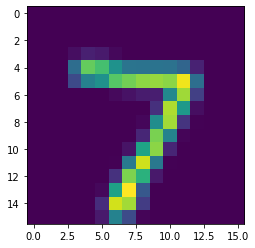

In [ ]:
plt.imshow(test_dataset[0][0].reshape(16, -1))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


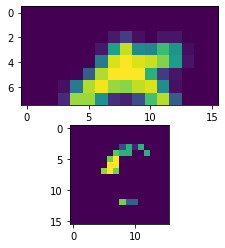

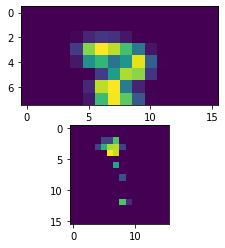

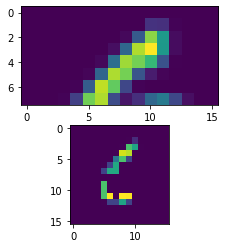

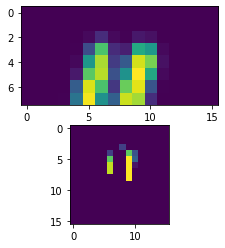

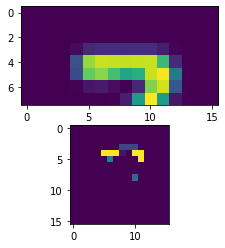

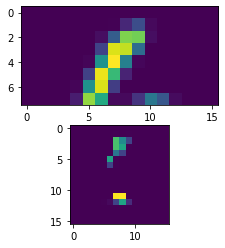

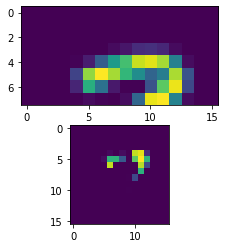

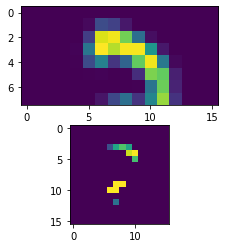

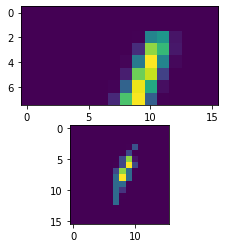

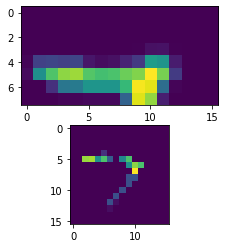

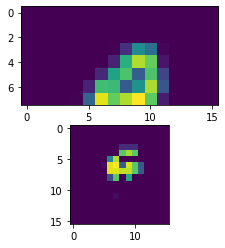

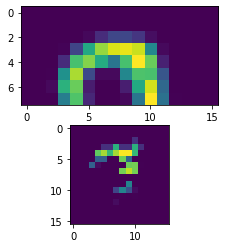

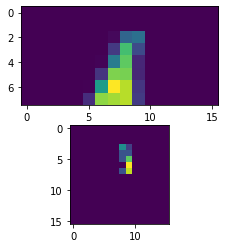

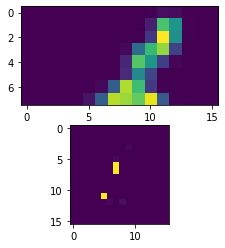

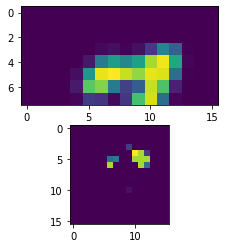

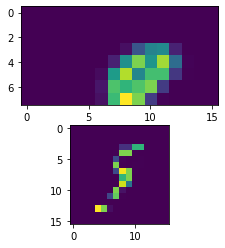

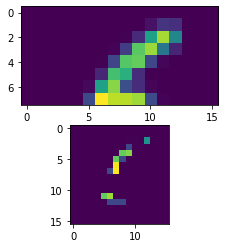

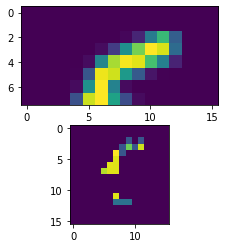

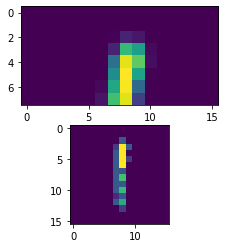

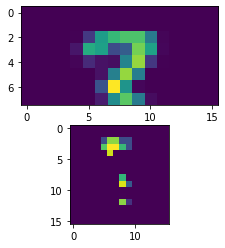

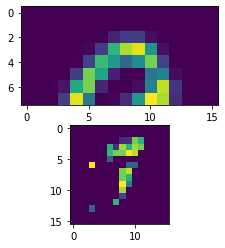

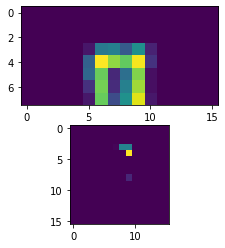

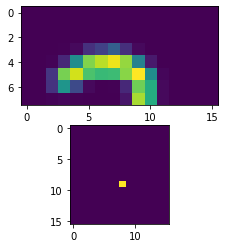

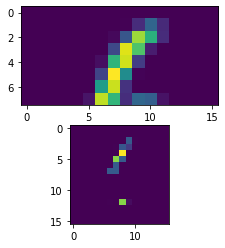

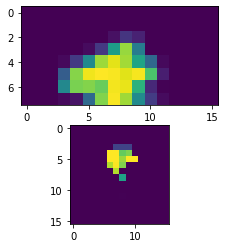

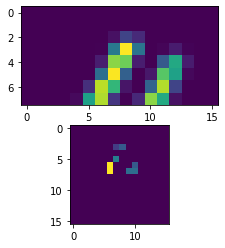

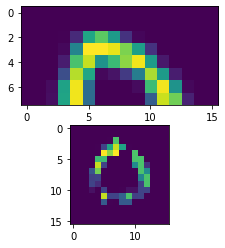

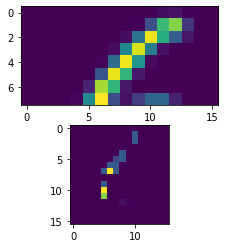

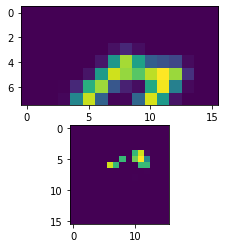

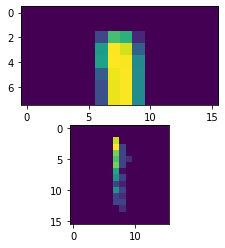

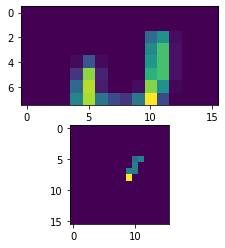

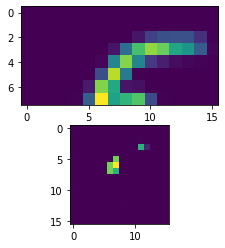

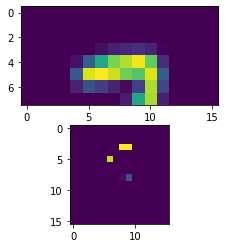

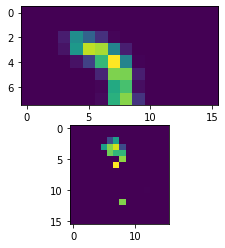

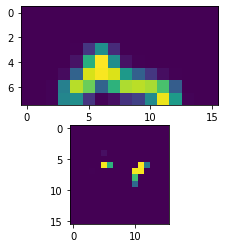

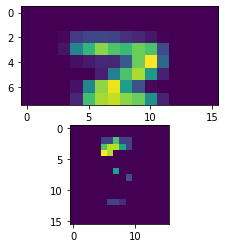

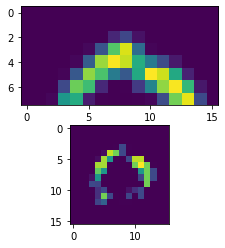

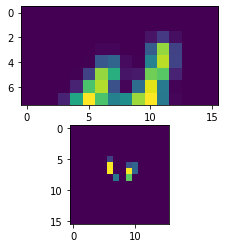

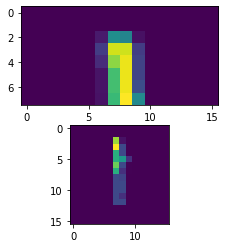

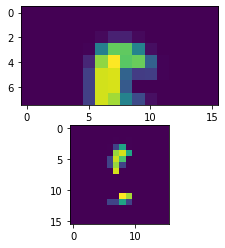

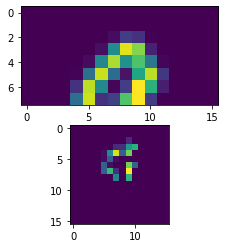

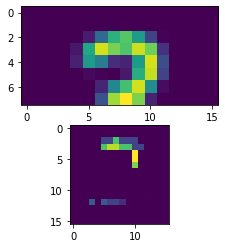

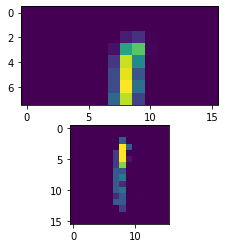

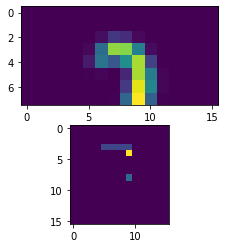

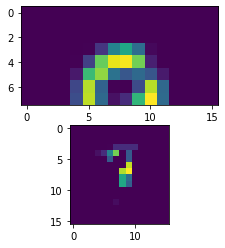

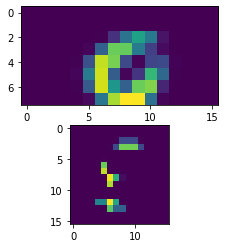

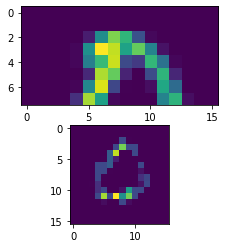

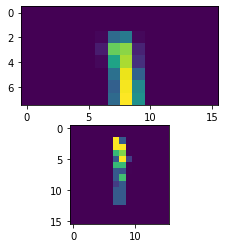

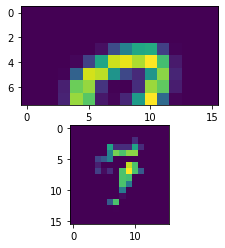

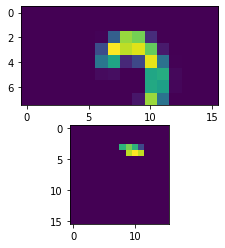

In [ ]:
from typing import Sequence
model = model.eval()
for i in [random.randint(1, 10000) for a in range(50)]:
  t = test_dataset[7][0].unsqueeze(0).cpu().numpy()
  inp_sequence = test_dataset[i][0].unsqueeze(0)
  tar=torch.tensor(test_dataset[i][1]).unsqueeze(0).to(DEVICE)
  idx=128
  fig, axes = plt.subplots(2)
  axes[0].imshow(test_dataset[i][0].unsqueeze(0).reshape(16, -1)[:8])
  seq = inp_sequence[:, :idx]
  #seq=inp_sequence[:]
  for i in range(256-idx+1):
    with torch.no_grad():
          # inp_sequence = quantize(inp_sequence, VOCAB_SIZE)
          inp_sequence = inp_sequence.to(DEVICE)
          seq = seq.to(DEVICE)
          #logits = model(inp_sequence, tar)
          logits = model(seq, tar)
          preds = torch.argmax(F.softmax(logits, -1)[0], axis=-1)[-1].view(1, -1)
          #inp_sequence = torch.cat([inp_sequence, preds], axis=1)
          seq =  torch.cat([seq, preds], axis=1)
  
  axes[1].imshow(torch.argmax(logits[0], axis=-1).reshape(-1,16).cpu().numpy())
  #axes[1].imshow(test_dataset[13][0].reshape(16, -1))
  #axes[1].imshow(test_dataset[13][0].reshape(16, -1)[:6])
  #axes[1].imshow(test_dataset[13][0][:,:128].reshape(16, -1))
  #plt.show()

  fig.savefig("image%s.png"%i)